In [2]:
from importlib.metadata import version
import cv2
import pixellib
import os
import urllib
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [3]:
# 모델 불러오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
# PixelLib가 제공하는 모델
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7d0826dd9730>)

In [4]:
model = semantic_segmentation() 
#PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듦
model.load_pascalvoc_model(model_file)

In [7]:
# pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

In [8]:
# 인물모드 이미지 만드는 함수
def img_bg_blur(img_path, model, LABEL_NAMES, object_label):
    # 오리지널 이미지 뽑기
    img_orig = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.show()
    
    # 모델에 이미지 입력
    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    # orig와 output 모양이 다를 경우
    while img_orig.shape != output.shape:
        output = cv2.rotate(output, cv2.ROTATE_90_CLOCKWISE) # 모양이 같아질 때까지 시계방향 90도씩 돌림
    
    # 모델 출력 결과 확인
    plt.imshow(output)
    plt.show()
    
    # 사진에 감지된 물체 리스트
    object_labels = []
    for class_id in segvalues['class_ids']:
        object_labels.append(LABEL_NAMES[class_id])
    
    if object_label in object_labels: # 사진 안에 원하는 물체가 있을 때
        print(object_labels)
        # 컬러맵 만들기 
        colormap = np.zeros((256, 3), dtype = int)
        ind = np.arange(256, dtype=int)
        for shift in reversed(range(8)):
            for channel in range(3):
                colormap[:, channel] |= ((ind >> channel) & 1) << shift
            ind >>= 3
        seg_bgr = colormap[LABEL_NAMES.index(object_label)] # 해당 라벨의 컬러맵 추출
        seg_rgb = (seg_bgr[2],seg_bgr[1],seg_bgr[0]) # bgr rgb 변경
    
    else : 
        print("Object is not in the image.") # 원하는 물체가 없을 때 : 그냥 사람으로 함
        seg_rgb = (128,128,192)


    # 물체인 부분을 True로 나타내는 seg_map 설정
    seg_map = np.all(output==seg_rgb, axis=-1)
    # True와 False를 각각 255와 0으로 바꿔줌
    img_mask = seg_map.astype(np.uint8) * 255
    # 흐린 이미지 만들기
    img_orig_blur = cv2.blur(img_orig, (50,50)) # blurring kernel size
    # 이미지 마스크의 색상 rgb로 변경
    img_mask_rgb = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    # 배경을 255, 사람을 0으로 바꾸기
    img_bg_mask = cv2.bitwise_not(img_mask_rgb)
    # 흐린 배경만 뽑기
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    # 흐린 배경과 맑은 사람 합성
    img_concat = np.where(img_bg_mask==0, img_orig, img_orig_blur)
    # 인물모드 이미지 출력
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.title("Focused Image")
    plt.show()
    return img_concat

In [13]:
# 크로마키 함수
def chromakey(img_path, bg_path, model, LABEL_NAMES):
    # 오리지널, 백그라운드용 이미지 뽑기
    img_orig = cv2.imread(img_path)
    img_bg = cv2.imread(bg_path)
    # 모델에 이미지 입력
    segvalues, output = model.segmentAsPascalvoc(img_path)
    # 모델 출력 결과 확인
    plt.imshow(output)
    plt.show()
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])
    # 오리지널에서 사람만 뽑기
    seg_color = (128,128,192)
    seg_map = np.all(output==seg_color, axis=-1) 
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_rgb = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_object = cv2.bitwise_and(img_orig, img_mask_rgb)
    plt.imshow(cv2.cvtColor(img_object, cv2.COLOR_BGR2RGB))
    plt.title("Object Image")
    plt.show()
    # 백그라운드용 위에 원본 사진 얹기
    bg_resize = cv2.resize(img_bg, img_orig.shape[:2])
    img_concat = np.where(img_mask_rgb==255, img_orig, bg_resize)
    # 크로마키 이미지 출력
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.title("Chromakey Image")
    plt.show()
    return img_concat

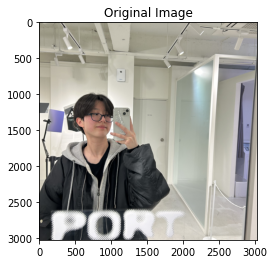

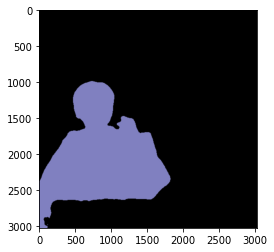

['background', 'person']


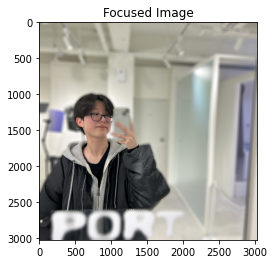

array([[[137, 153, 156],
        [137, 153, 156],
        [137, 153, 156],
        ...,
        [134, 146, 152],
        [134, 146, 152],
        [134, 146, 152]],

       [[137, 153, 156],
        [137, 153, 156],
        [137, 153, 156],
        ...,
        [134, 146, 152],
        [134, 146, 152],
        [134, 146, 152]],

       [[137, 153, 156],
        [137, 153, 156],
        [137, 153, 156],
        ...,
        [134, 146, 152],
        [134, 146, 152],
        [134, 146, 152]],

       ...,

       [[ 44,  40,  39],
        [ 48,  44,  43],
        [ 50,  46,  45],
        ...,
        [206, 212, 222],
        [206, 212, 222],
        [206, 212, 222]],

       [[ 49,  45,  44],
        [ 46,  42,  41],
        [ 46,  42,  41],
        ...,
        [206, 212, 222],
        [206, 212, 222],
        [206, 212, 222]],

       [[ 50,  46,  45],
        [ 45,  41,  40],
        [ 47,  43,  42],
        ...,
        [206, 212, 222],
        [206, 212, 222],
        [206, 212, 222]]

In [11]:
# 실험 1. 인물 사진
img_path = os.getenv('HOME')+'/aiffel/인물.jpg'  
img_bg_blur(img_path, model, LABEL_NAMES, 'person')

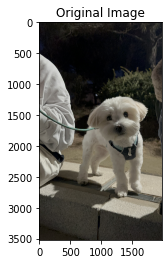

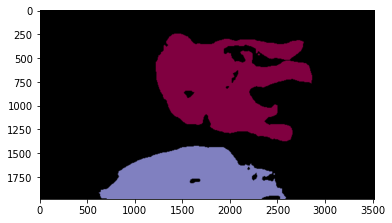

['background', 'dog', 'person']


error: OpenCV(4.5.3) /tmp/pip-req-build-agffqapq/opencv/modules/core/src/arithm.cpp:212: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and type), nor 'array op scalar', nor 'scalar op array' in function 'binary_op'


In [58]:
# 실험 2. 강아지 사진
img_path_dog = os.getenv('HOME')+'/aiffel/동물.jpg'  
img_bg_blur(img_path_dog, model, LABEL_NAMES, 'dog')

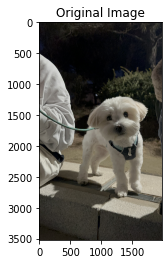

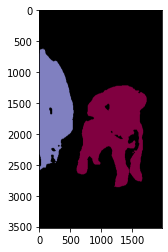

['background', 'dog', 'person']


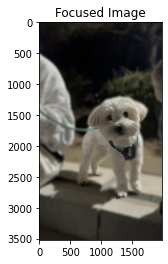

array([[[23, 21, 23],
        [23, 21, 23],
        [23, 21, 23],
        ...,
        [29, 25, 20],
        [29, 25, 20],
        [29, 25, 20]],

       [[23, 21, 23],
        [23, 21, 23],
        [23, 21, 23],
        ...,
        [29, 25, 20],
        [29, 25, 20],
        [29, 25, 20]],

       [[23, 21, 23],
        [23, 21, 23],
        [23, 21, 23],
        ...,
        [29, 25, 20],
        [29, 25, 20],
        [29, 25, 20]],

       ...,

       [[21, 28, 33],
        [21, 28, 33],
        [21, 28, 33],
        ...,
        [27, 29, 33],
        [27, 29, 33],
        [27, 29, 33]],

       [[21, 28, 33],
        [21, 28, 33],
        [21, 28, 33],
        ...,
        [27, 29, 33],
        [27, 29, 33],
        [27, 29, 33]],

       [[22, 28, 33],
        [22, 28, 33],
        [22, 28, 33],
        ...,
        [27, 29, 33],
        [27, 29, 33],
        [27, 29, 33]]], dtype=uint8)

In [61]:
# 실험 2-1. output 이미지가 돌아감. 왜지?
# 함수 코드 수정
img_bg_blur(img_path_dog, model, LABEL_NAMES, 'dog')

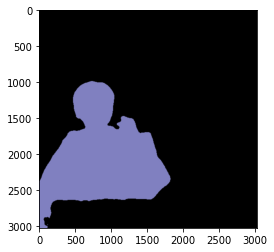

background
person


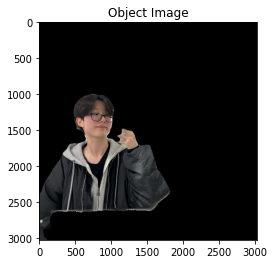

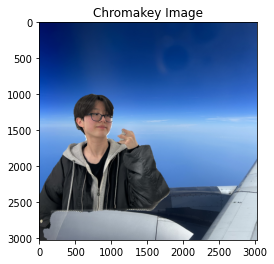

array([[[ 97,  14,   0],
        [ 97,  14,   0],
        [ 97,  14,   0],
        ...,
        [128,  64,  29],
        [128,  64,  29],
        [128,  64,  29]],

       [[ 97,  14,   0],
        [ 97,  14,   0],
        [ 97,  14,   0],
        ...,
        [128,  64,  29],
        [128,  64,  29],
        [128,  64,  29]],

       [[ 97,  14,   0],
        [ 97,  14,   0],
        [ 97,  14,   0],
        ...,
        [128,  64,  29],
        [128,  64,  29],
        [128,  64,  29]],

       ...,

       [[ 44,  40,  39],
        [ 48,  44,  43],
        [ 50,  46,  45],
        ...,
        [202, 192, 182],
        [202, 192, 182],
        [202, 192, 182]],

       [[ 49,  45,  44],
        [ 46,  42,  41],
        [ 46,  42,  41],
        ...,
        [202, 192, 182],
        [202, 192, 182],
        [202, 192, 182]],

       [[ 50,  46,  45],
        [ 45,  41,  40],
        [ 47,  43,  42],
        ...,
        [202, 192, 182],
        [202, 192, 182],
        [202, 192, 182]]

In [14]:
# 실험 3. 크로마키
img_path_bg = os.getenv('HOME')+'/aiffel/하늘.jpg'  
chromakey(img_path, img_path_bg, model, LABEL_NAMES)

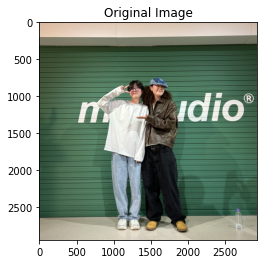

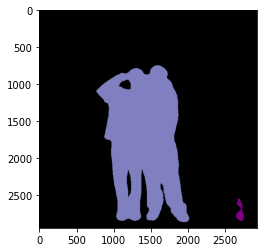

['background', 'bottle', 'person']


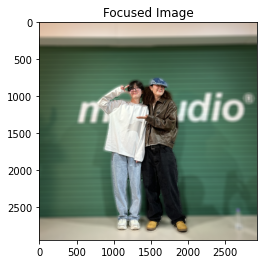

array([[[160, 185, 219],
        [160, 185, 219],
        [160, 185, 219],
        ...,
        [163, 179, 199],
        [163, 179, 199],
        [163, 179, 199]],

       [[160, 185, 219],
        [160, 185, 219],
        [160, 185, 219],
        ...,
        [163, 179, 199],
        [163, 179, 199],
        [163, 179, 199]],

       [[160, 185, 219],
        [160, 185, 219],
        [160, 185, 219],
        ...,
        [163, 179, 199],
        [163, 179, 199],
        [163, 179, 199]],

       ...,

       [[150, 167, 176],
        [150, 167, 176],
        [150, 167, 176],
        ...,
        [148, 166, 173],
        [148, 166, 173],
        [148, 166, 173]],

       [[150, 167, 176],
        [150, 167, 176],
        [150, 167, 176],
        ...,
        [148, 166, 173],
        [148, 166, 173],
        [148, 166, 173]],

       [[150, 167, 176],
        [150, 167, 176],
        [150, 167, 176],
        ...,
        [148, 166, 173],
        [148, 166, 173],
        [148, 166, 173]]

In [16]:
# 실험 4. 사람이 2명
img_path_two = os.getenv('HOME')+'/aiffel/크로마키.jpg'  
img_bg_blur(img_path_two, model, LABEL_NAMES, 'person')

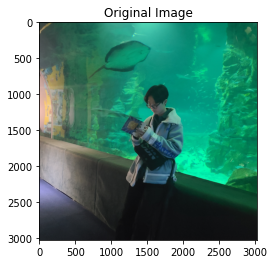

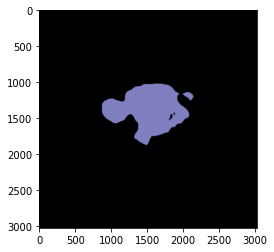

['background', 'person']


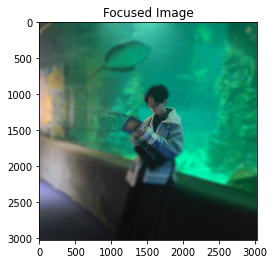

array([[[ 66,  71,  56],
        [ 66,  71,  56],
        [ 66,  71,  56],
        ...,
        [ 83, 107,  24],
        [ 83, 107,  24],
        [ 83, 108,  24]],

       [[ 66,  71,  56],
        [ 66,  71,  56],
        [ 66,  71,  56],
        ...,
        [ 83, 107,  24],
        [ 83, 107,  24],
        [ 83, 108,  24]],

       [[ 66,  71,  56],
        [ 66,  71,  56],
        [ 66,  71,  56],
        ...,
        [ 83, 107,  24],
        [ 83, 107,  24],
        [ 83, 107,  24]],

       ...,

       [[ 42,  37,  33],
        [ 42,  37,  33],
        [ 42,  37,  33],
        ...,
        [ 19,  17,  17],
        [ 19,  17,  17],
        [ 19,  17,  17]],

       [[ 42,  37,  33],
        [ 42,  37,  33],
        [ 42,  37,  33],
        ...,
        [ 19,  17,  17],
        [ 19,  17,  17],
        [ 19,  17,  17]],

       [[ 42,  37,  33],
        [ 42,  37,  33],
        [ 42,  37,  33],
        ...,
        [ 18,  16,  16],
        [ 18,  16,  16],
        [ 18,  16,  16]]

In [17]:
# 실험 4. 어두운 사진
img_path_dark = os.getenv('HOME')+'/aiffel/크로마키2.jpg'  
img_bg_blur(img_path_dark, model, LABEL_NAMES, 'person')

In [ ]:
# 회고
"""
크로마키 인물이랑 배경이 바뀌는 에러가 웃겨서 남겨두려고 했는데 잘못 눌러서 날렸다. 아쉽다

핸드폰을 들고 있는 손가락 부분을 인식하지 못한다.
강아지의 경우에는 하네스와 털을 매우 잘 구분함. 그런데 발 부분을 잘 인식하고 있는데 왜 블러 처리된지 모르겠다.

segmentation의 문제점
1. 주변 인물들도 같이 인식된다.
2. 오브젝트가 들고 있거나 쓰고 있는 물체는 다른 객체로 인식된다.
3. 오브젝트가 만드는 빈 공간을 잘 인식하지 못한다.
4. 모델에 넣고 결과 뽑을 때 왜 돌아가는거지?? 돌아가는 경우와 안돌아가는 경우의 차이가 뭐지? 모르겠다.

솔루션
1. 모델 학습 시 다른 메트릭 사용
2. 사진만으로 깊이를 알수있는방법 → 깊이 탐지 딥러닝 기술
3. 카메라에 달린다른 기능을 이용하는 방법 → 적외선 input을 통해 깊이를 탐색하는 방법
4. 해상도를 올려주는 기능을 사용하기
5. 파인튜닝을 이용해서 분류기 부분의 범주를 줄이기
"""